In [1]:
import pandas as pd
import numpy as np
from functions import impute_knn

df = pd.read_csv('housing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [2]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Using the info method we can see that some values are not attributed. We have to fill these in to ensure data consistency.

In [3]:
df = impute_knn(df)
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The original data always looked at the housing data per district. For my use case I want to look at it per house which is why I add some fields, rename some columns and delete no longer necessary columns in the following.

In [4]:
#turn this into a function in the end
df['rooms'] = df['total_rooms'] / df['households']
df['bedrooms'] = df['total_bedrooms'] / df['households']
df['number_of_people'] = df['population'] / df['households']

#create the average rooms per house for a district derived from the number of rooms and households in the district. Rounding makes sure it only takes whole numbers
df['rooms'] = df['rooms'].round(0).astype(int)

#Same procedure as with the rooms
df['bedrooms'] = df['bedrooms'].round(0).astype(int)
df['number_of_people'] = df['number_of_people'].round(0).astype(int)
df.rename(columns={"housing_median_age": "house_age", "median_income": "monthly_income_in_k_USD",  "median_house_value": "house_value"}, inplace = True)
drop_list = ["ocean_proximity", "total_rooms", "total_bedrooms", "households", "population"]
for element in drop_list:
    df.drop(element, axis=1, inplace=True)
df.head()

,longitude,latitude,house_age,monthly_income_in_k_USD,house_value,rooms,bedrooms,number_of_people
0,-122.23,37.88,41.0,8.3252,452600.0,7,1,3
1,-122.22,37.86,21.0,8.3014,358500.0,6,1,2
2,-122.24,37.85,52.0,7.2574,352100.0,8,1,3
3,-122.25,37.85,52.0,5.6431,341300.0,6,1,3
4,-122.25,37.85,52.0,3.8462,342200.0,6,1,2


Now, I look at the data to find any outliers or other issues with data that need to be fixed.

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'house_age'}>],
       [<AxesSubplot:title={'center':'monthly_income_in_k_USD'}>,
        <AxesSubplot:title={'center':'house_value'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'number_of_people'}>,
        <AxesSubplot:>]], dtype=object)

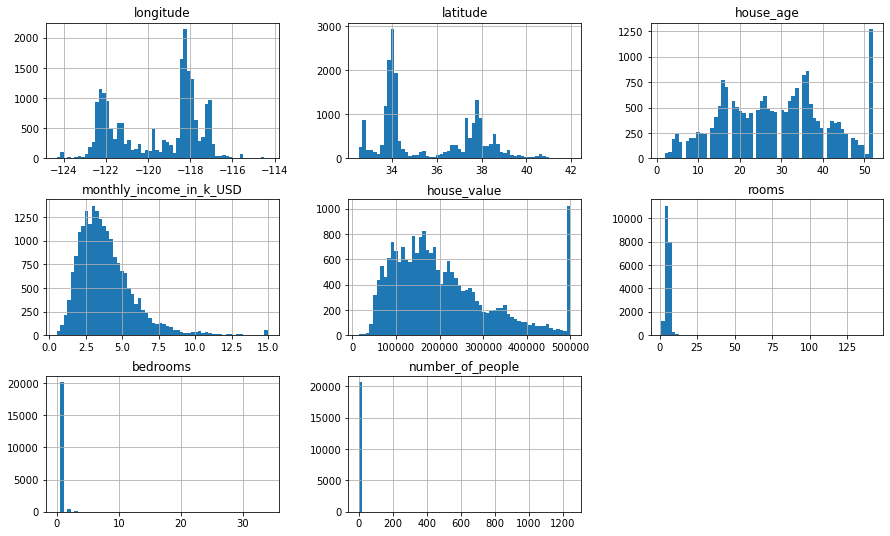

In [5]:
df.hist(bins=60, figsize=(15,9))

There seems to be an issue with the house value having a lot of outliers in the maximum. Therefore, I want to get of these and print the code again to see if the adjustment fixed the issue. 

Index(['longitude', 'latitude', 'house_age', 'monthly_income_in_k_USD',
       'house_value', 'rooms', 'bedrooms', 'number_of_people'],
      dtype='object')


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'house_age'}>],
       [<AxesSubplot:title={'center':'monthly_income_in_k_USD'}>,
        <AxesSubplot:title={'center':'house_value'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'number_of_people'}>,
        <AxesSubplot:>]], dtype=object)

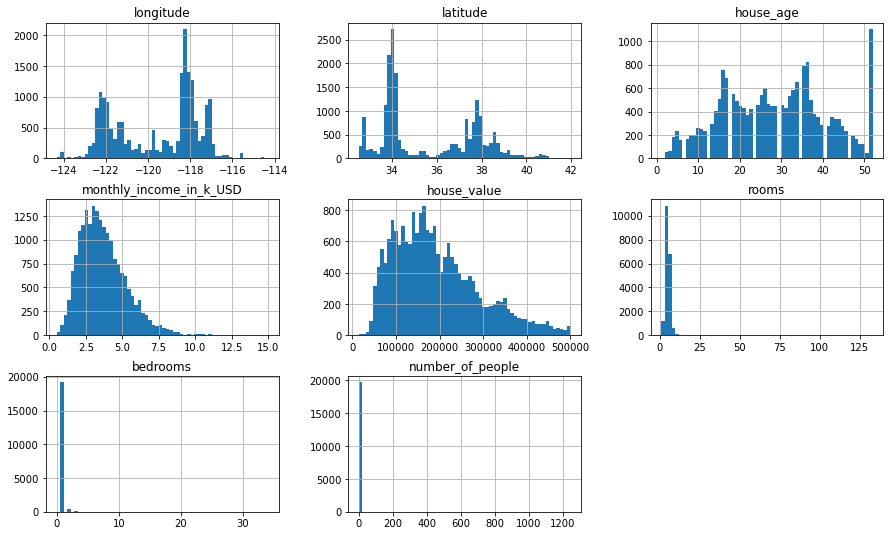

In [6]:
#changed code from original idea, same source as impute_knn function
maxval = df['house_value'].max()
df = df[df['house_value'] != maxval]
print(df.columns)
df.hist(bins=60, figsize=(15,9))

In [7]:
#save the data as a cv to be used in the method for estimating the house price using linear regression
df.to_csv('final_data.csv')